# 3.01 Stable Isotope Calculation Templates - Mg isotopes
*Simon Matthews (simonm@hi.is), July 2024*

---

This notebook is intended to be a starting point for setting up calculations of stable Mg isotope fractionation during multi-component mantle melting. See other templates to set up a different set of lithologies, if you want to calculate trace elements, or to model other stable isotope systems.

The calculations here loosely follow those outlined in Soderman et al. (2022), except for explicitly considering magma aggregation.

Though I have added some description of each step, to find a more comprehensive account of why the calculation is structured the way it is see the pyMelt documentation and tutorials.

## 1. Preliminaries

Import required packages:

In [1]:
import pyMelt as m
import numpy as np
import matplotlib.pyplot as plt

Retrieve a lherzolite and pyroxenite lithology. In this case, the parameterisations of KLB1 and KG1 given in Matthews et al. (2021). KLB1 represents fertile lherzolite mantle, and KG1 represents a mixture between a MORB-like eclogite composition and lherzolite. These lithologies have thermocalc phase diagrams attached.

In [2]:
lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()

Create a mantle object with 10% pyroxenite:

In [3]:
mantle = m.mantle([lz, px], [0.9, 0.1], ['lz', 'px'])

## 2. Melt the mantle

Melt the mantle assuming a $T_p$=1330˚C to produce a melting column of incremental melts.

In [4]:
column = mantle.adiabaticMelt(1330.0)

We can visualise the results of the melting calculation:

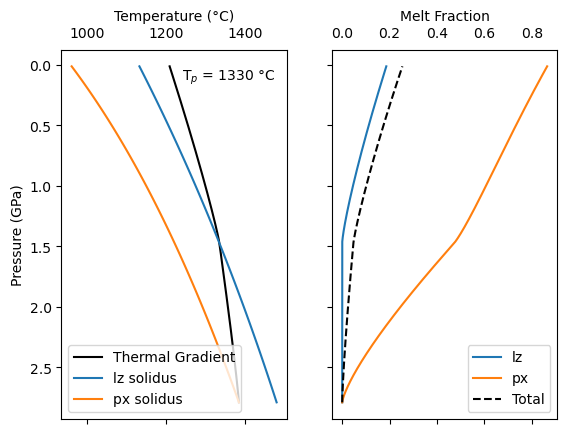

In [5]:
f, a = column.plot()

## 3. Calculate chemical properties of the melting column
First, calculate the residuum mineralogy at each step. The mineral proportions are extracted from the phase diagram attached to each lithology. This is required by the Fe-isotope calculations:

In [6]:
column.calculateMineralProportions()

We can see the results by plotting them directly:

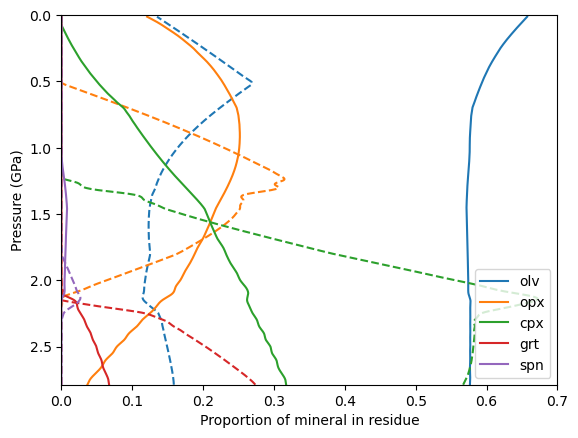

In [8]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:
    a.plot(column.composition['lz'][min], column.P, c=colours[min], label=min)
    a.plot(column.composition['px'][min], column.P, c=colours[min], ls='--')

a.legend(loc='lower right')
a.set_xlabel('Proportion of mineral in residue')
a.set_ylabel('Pressure (GPa)')

a.set_xlim(0, 0.7)
a.set_ylim(np.nanmax(column.P), 0.0)

plt.show()

The final information needed before we can calculate stable isotopes is the MgO content of each of the phases at each step. This information is looked up from the phase diagram attached to each lithology.

In [9]:
column.calculateMajorOxides()

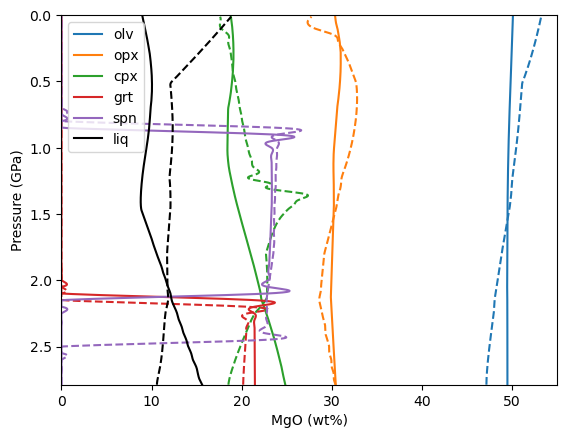

In [17]:
f, a = plt.subplots(sharey='row')

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4', 'liq': 'k'}

for min in ['olv', 'opx', 'cpx', 'grt', 'spn', 'liq']:
    a.plot(column.composition['lz'][min+'_MgO'], column.P,
              c=colours[min], label=min)
    a.plot(column.composition['px'][min+'_MgO'], column.P, 
              c=colours[min], ls='--')

    
a.set_ylim(np.nanmax(column.P), 0.0)
a.set_xlim(0, 55)

a.set_ylabel('Pressure (GPa)')
a.set_xlabel('MgO (wt%)')

a.legend()

plt.show()

All of these results are now embedded in the melting column object, and so they can now be used by the stable isotope calculations.

## 4. Setup stable isotope calculations

A mineral-melt fractionation factor must be defined for each mineral, as well as the Mg isotope ratio of solid lithology before melting. 

We must define a function that will use these parameters to derive the fractionation factor:

In [21]:

def WangBetaEqn(T, P, a, b, c, d, e, f, g, h, i):
    return ((a + b*P + c*P**2) * 1e6 / T**2 + (d + e*P + f*P**2) * (1e6/T**2)**2 
            + (g + h*P + i*P**2) * (1e6/T**2)**3)

def ff_olv(state, phaseDiagram):
    return 0.0

def olv_ref(state, phaseDiagram):
    olv = WangBetaEqn(state['T'] + 273.15, state['P'], 2.076, 7.183e-2, -4.672e-4, 
                       1.049e-1, -3.359e-3, 5.009e-5, -1.192e-2, 2.739e-4, -5.518e-6)
    return olv

def ff_cpx(state, phaseDiagram):
    olv = WangBetaEqn(state['T'] + 273.15, state['P'], 2.076, 7.183e-2, -4.672e-4, 
                       1.049e-1, -3.359e-3, 5.009e-5, -1.192e-2, 2.739e-4, -5.518e-6)
    return WangBetaEqn(state['T'] + 273.15, state['P'], 2.246, 8.548e-2, -7.425e-4, 
                       1.025e-1, -3.369e-3, 5.172e-5, -1.169e-2, 2.834e-4, -5.514e-6) - olv

def ff_opx(state, phaseDiagram):
    olv = WangBetaEqn(state['T'] + 273.15, state['P'], 2.076, 7.183e-2, -4.672e-4, 
                       1.049e-1, -3.359e-3, 5.009e-5, -1.192e-2, 2.739e-4, -5.518e-6)
    return WangBetaEqn(state['T'] + 273.15, state['P'], 2.246, 6.206e-2, -0.733e-4, 
                       0.675e-1, -0.141e-3, -8.619e-5, -0.817e-2, -0.657e-4, 8.825e-6) - olv

def ff_grt(state, phaseDiagram):
    olv = WangBetaEqn(state['T'] + 273.15, state['P'], 2.076, 7.183e-2, -4.672e-4, 
                       1.049e-1, -3.359e-3, 5.009e-5, -1.192e-2, 2.739e-4, -5.518e-6)
    return WangBetaEqn(state['T'] + 273.15, state['P'], 1.302, 
                       2.732e-2, 
                       1.784e-4, 
                       0.492e-1, 1.266e-3, -4.067e-5, -0.554e-2, -1.482e-4, 3.787e-6) - olv

def ff_spn(state, phaseDiagram):
    olv = WangBetaEqn(state['T'] + 273.15, state['P'], 2.076, 7.183e-2, -4.672e-4, 
                       1.049e-1, -3.359e-3, 5.009e-5, -1.192e-2, 2.739e-4, -5.518e-6)
    return WangBetaEqn(state['T'] + 273.15, state['P'], 3.058, 6.216e-2, -3.720e-4, 
                       0.847e-1, -3.421e-3, 5.116e-5, -1.132e-2, 2.555e-4, -5.551e-6) - olv

We can check that these functions produce the numbers we expect.

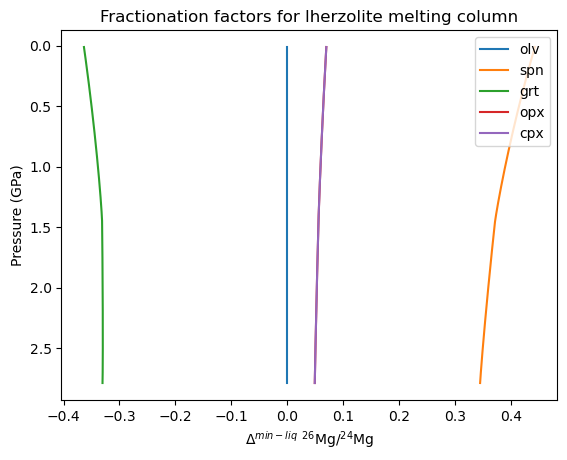

In [23]:
alpha = np.zeros([5, len(column.P)])
for i, row in column.composition['lz'].iterrows():
    alpha[0, i] = (ff_olv(row, lz.phaseDiagram))
    alpha[1, i] = (ff_spn(row, lz.phaseDiagram))
    alpha[2, i] = (ff_grt(row, lz.phaseDiagram))
    alpha[3, i] = (ff_opx(row, lz.phaseDiagram))
    alpha[4, i] = (ff_cpx(row, lz.phaseDiagram))

f, a = plt.subplots()

a.plot(alpha[0,:], column.P, label='olv')
a.plot(alpha[1,:], column.P, label='spn')
a.plot(alpha[2,:], column.P, label='grt')
a.plot(alpha[3,:], column.P, label='opx')
a.plot(alpha[3,:], column.P, label='cpx')

a.invert_yaxis()

a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\Delta^{min-liq}$ $^{26}$Mg/$^{24}$Mg')


# a.xaxis.set_major_formatter("{x:.6f}")

a.set_title("Fractionation factors for lherzolite melting column")

a.legend()

plt.show()

## 5. Do stable isotope calculation

Now we need to feed all of this information to pyMelt, along with the bulk composition of each mantle component. 

For the bulk composition, we will follow Soderman et al. (2024) and use:

In [25]:
d26_lz = -0.24
d26_px = -0.25

In [27]:
column.calculateStableIsotopes(species='MgO',
                               fractionationFactors={'olv': ff_olv,
                                                     'opx': ff_opx,
                                                     'cpx': ff_cpx,
                                                     'grt': ff_grt,
                                                     'spn': ff_spn,
                                                     'plg': 0.0},
                                isotopeRatioLabel='d26Mg', # The label to be used in the results table
                                bulk={'lz': d26_lz,
                                      'px': d26_px},
                                fractionalExtraction= False, # Can approximate fractional extraction of melts by setting to True
                                porosity= 0.0 # Can do continueous melting (when fractional extraction enabled) by defining a porosity
                                )

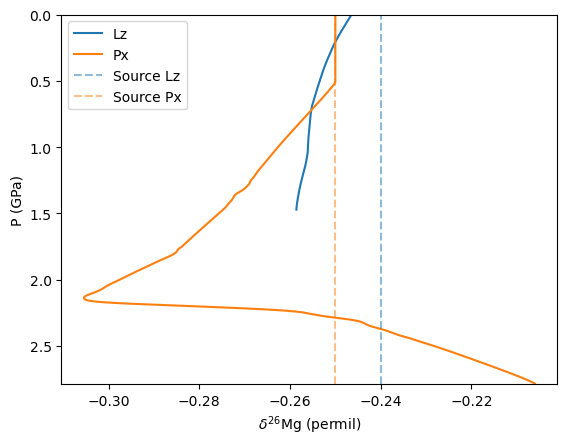

In [29]:
f, a = plt.subplots()

a.plot(column.composition['lz']['liq_d26Mg'], column.P, label='Lz')
a.plot(column.composition['px']['liq_d26Mg'], column.P, label='Px')

a.axvline(d26_lz, c='C0', alpha=0.5, ls='--', label='Source Lz')
a.axvline(d26_px, c='C1', alpha=0.5, ls='--', label='Source Px')


a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{26}$Mg (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='upper left')

plt.show()

We can also see how the solid residue changes in composition throughout melting:

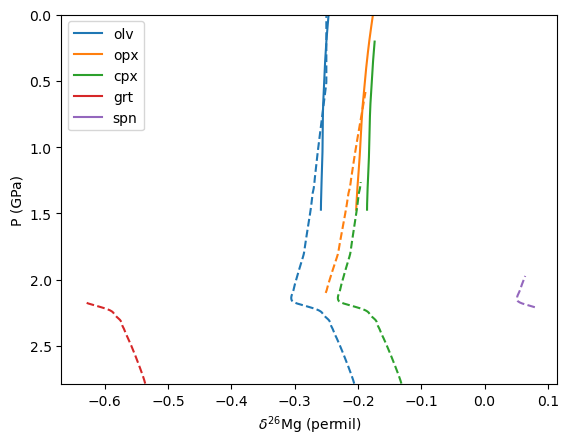

In [32]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:

    a.plot(column.composition['lz'][min+'_d26Mg'], column.P, label=min, c=colours[min])
    a.plot(column.composition['px'][min+'_d26Mg'], column.P, ls='--', c=colours[min])

a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{26}$Mg (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='upper left')

plt.show()

## 6. Find the aggregated melt composition
For this calculation we will assume we are at a mid-ocean ridge. See other templates for OIB melting.

We have to create a geosetting from the melting column. In doing this, pyMelt will calculate the crustal thickness (and therefore the depth at which melting should terminate) as well as calculating the weighting for each melt batch, assuming a triangular melting region.

In [33]:
mor = m.geosettings.spreadingCentre(column)

Find the aggregated $\delta^{26}$Mg:

In [34]:
mor.chemistry.liq_d26Mg

-0.2573485027877304

## 7. What next?

The purpose of this template is to set out how to get results for Mg stable isotope fractionation only. It is likely you will also want to calculate other things, e.g., the trace element composition, or the radiogenic isotope ratios of the homogenized melt. Perhaps you want this as a function of $T_p$, mantle composition, or geodynamic setting. All of this is possible, but will require combining the code from different templates.

## References

Matthews, S., Wong, K., Shorttle, O., Edmonds, M., & Maclennan, J. (2021). Do olivine crystallization temperatures faithfully record mantle temperature variability? Geochemistry, Geophysics, Geosystems, 22, e2020GC009157. https://doi.org/10.1029/2020GC009157

Soderman, C. R., Shorttle, O., Matthews, S., & Williams, H. M. (2022). Global trends in novel stable isotopes in basalts: Theory and observations. Geochimica et Cosmochimica Acta, 318, 388-414. https://doi.org/10.1016/j.gca.2021.12.008 

Soderman, C. R., Matthews, S., Shorttle, O., Jackson, M. G., Day, J. M., Kamenetsky, V., & Williams, H. M. (2024). Global oceanic basalt sources and processes viewed through combined Fe and Mg stable isotopes. Earth and Planetary Science Letters, 638, 118749. https://doi.org/10.1016/j.epsl.2024.118749 

Wang, W., Wu, Z., Huang, S., & Huang, F. (2023). First-principles investigation of equilibrium magnesium isotope fractionation among mantle minerals: review and new data. Earth-Science Reviews, 237, 104315. https://doi.org/10.1016/j.earscirev.2023.104315 